# Subset discontinuity tracking
This deck contains proofing of subset splitting methodologies

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

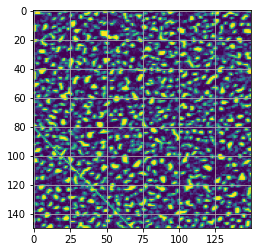

In [2]:
# preamble
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset
import os
import cv2

# folder path

folder_path=Path(r'C:\Users\alexb\Desktop\crosspy\data\Disc_tester')
Images = Imset(folder_path,'tif')

# Image crop

crop_on = False

if crop_on:
    img = Images.imload([0,1])
    y = 175
    h = 1000
    x = 525
    w = 1000
    Images = img[y:y+h, x:x+w, :]
else:
    Images = Images.imload([0,1])
   
fig = plt.figure()
ax = fig.gca()
ax.imshow(Images[:,:,1])
#ax.set_xticks(np.arange(0, Images.shape[0], Images.shape[0]/10))
#ax.set_yticks(np.arange(0, Images.shape[1], Images.shape[1]/10))
plt.grid()


361
Running sequential DIC on image pair 1 of 1 ...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 361 out of 361 | elapsed:    0.3s finished
... Completed in (s) 0.42437314987182617
Calculating strain on map 1 of 1 ...
... Completed in (s) 0.2872326374053955
Quick plotting strains


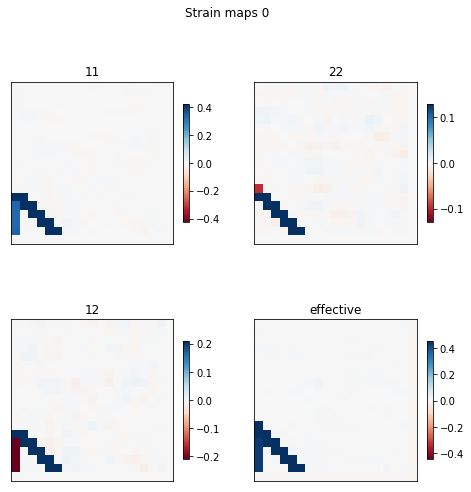

 
*** Profile printout saved to text file 'prun0'. 


In [5]:
%%prun -s cumulative -q -l 10 -T prun0
# Image crop

roi_1stpass = dict(size_pass = 32, overlap_percentage = 80, xcf_mesh=32)
filter_settings = [4,2,15,8]
# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)

print(dic_1stpass.n_subsets)
dic_1stpass.run_sequential(cores=1,hs=False)

# dic_1stpass.plot_displacements()
dic_1stpass.calculate_strain()
dic_1stpass.plot_strains()

In [ ]:
dic_1stpass.plot_displacements()




eff = dic_1stpass.strain_eff[:,:,0]
e11 = dic_1stpass.strain_11[:,:,0]
e22 = dic_1stpass.strain_22[:,:,0]
e12 = dic_1stpass.strain_12[:,:,0]
fig,ax = plt.subplots()


im1 = ax.imshow(eff, vmin=0,vmax=0.01, cmap="inferno")

fig.colorbar(im1, ax=ax, shrink=0.8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
print(open('prun0', 'r').read())

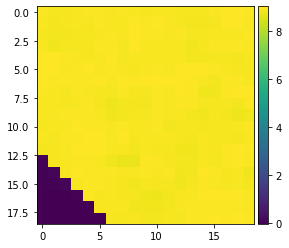

In [12]:
cc_peaks = dic_1stpass.ph_maps[:,:,0]
dx_maps = dic_1stpass.dx_maps[:,:,0]
dy_maps = dic_1stpass.dy_maps[:,:,0]
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot(111)
im = ax.imshow(dy_maps)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

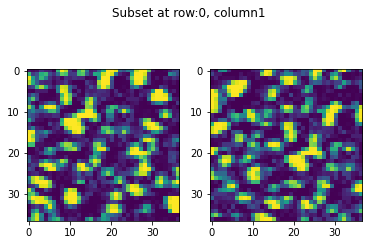

In [7]:
import cv2
filter_settings=[4,2,15,8]
ims = Images
#settings for heaviside pass
roi_disc = dict(size_pass = 37, overlap_percentage = 80, xcf_mesh=30)
dic_disc = DIC(ims, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=3, col=1, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets


    
# Select a subset, here at row 20, column 20

#subsets = get_subsets(ims,5, 0, roi_disc) # has slip
subsets = get_subsets(ims,0,1, roi_disc) # has no slip


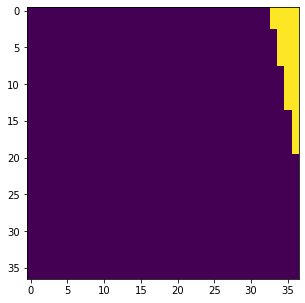

In [8]:

from numba import double, jit
from numba import int32, float32, uint8, jitclass
import numpy as np


# Apply a line and step function

spec = [
    ('x', float32),
    ('y', float32)
]

@jitclass(spec)
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 

@jit(nopython=True)
def line_test(pixel, r, theta, subsets):
    # function to test if a pixel lies above or below a line segment
    # Find start and end points of line segments for different cases of theta and r
    dx = subsets.shape[0]
    # Line segment to interogation point
    p1 = Point(0, 0)
    q1 = Point(pixel[0], pixel[1])
    
    # Vector magnitude cases
    #theta = np.degrees(theta)
    theta = theta % 360
    if r == 0:
        r = 1e-8
        
    # Rotation cases
    if theta == 0. or theta == 360.: # vertical to right
        x1 = r
        x2 = q1.x
        if x2 > x1:
            return False
        else:
            return True
    elif theta == 90.: # horizontal line above
        y1 = r
        y2 = q1.y
        if y2>y1:
            return False
        else:
            return True
    elif theta == 180.: # vertical to left
        x1 = -r
        x2 = q1.x
        if x2 > x1:
            return True
        else:
            return False
    elif theta == 270.: # horizontal below
        y1 = -r
        y2 = q1.y
        if y2 < y1:
            return False
        else:
            return True
    elif theta>0 and theta<180:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1>y2:
            return False
        else:
            return True
    elif theta>180 and theta<360:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1<y2:
            return False
        else:
            return True

@jit(uint8[:,:,:](uint8[:,:,:], float32, float32)) 
def gen_hsfilter(subsets, r, theta):
    # preallocate arrays
    hsfilter = np.zeros((subsets.shape[0],subsets.shape[0]), dtype="bool")
    xc = hsfilter.shape[0]/2
    yc = hsfilter.shape[1]/2
    xc = (xc)
    yc = (yc)

    # Create x and y coordinates which are centred
    xs,ys = np.meshgrid(np.linspace(-xc, xc,subsets.shape[0]), np.linspace(-yc,yc,subsets.shape[0]))

    # iterate pixel by pixel
    for col in range(subsets.shape[0]):
        for row in range(subsets.shape[0]):
            #rasters through columns and rows for a given coordinate in xy
            x = xs[row,col]
            y = ys[row,col]
            # Note that y axis is mirrored
            pixel = [x, (-1*y)]
            # Test if pixel is beyond the discontinuity line
            flag  =line_test(pixel, r, theta, subsets)
            if flag:
                hsfilter[row,col] = True
            else:
                hsfilter[row,col] = False
                
    return hsfilter



result = gen_hsfilter(subsets,r=18, theta=10)
result = ~result


f, ax = plt.subplots(figsize=(10,5))
ax.imshow(result[:,:])


In [9]:
import numpy as np
from scipy.signal import fftconvolve

def ncc(b, a, mode="full"):
    """
    b is deformed subset
    a is reference subset

    This is a matlab port following Ujash Joshi, University of Toronto, 2017
    """

    # If this happens, it is probably a mistake
    if np.ndim(b) > np.ndim(a) or \
            len([i for i in range(np.ndim(b)) if b.shape[i] > a.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = b - np.mean(b)
    image = a - np.mean(a)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)
    unout = out
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0

    CCmax=np.abs(np.amax(out))
    loc=np.argmax(out)
    loc1,loc2=np.unravel_index(loc,out.shape)

    row_shift=loc1-a.shape[0]
    col_shift=loc2-a.shape[0]

    return col_shift, row_shift, CCmax

ncc(subsets[:,:,1],subsets[:,:,0])

(-11, -10, 0.7464591488683348)


Testing various correlation functions below

# FREG hs corr:

---> FXCORR is already the fastests and most accurate function available --> alternatively rewrite as a lightweight correlation function without subpixel registration

In [ ]:
from crosspy import XCF

def hs_corr(x, subsets, dic, prepared_ffts):
    # unpack vector
    r, theta = x
    # generate heaviside filter
    hsfilter = gen_hsfilter(subsets, r, theta)
    
    # assign to clean variables for legibility
    a = subsets[:,:,0]#*hsfilter
    b = subsets[:,:,1]*hsfilter
    
    # cross correlate using freg - this is still faster than silly numpy correlate
    results = XCF.fxcorr(a, b, dic, prepared_ffts)
    # invert selection
    hsfilter_inv = ~hsfilter

    # apply to clean variables
    c = subsets[:,:,0]# * hsfilter_inv
    d = subsets[:,:,1] * hsfilter_inv

    results_inv = XCF.fxcorr(c, d, dic, prepared_ffts)


    
    # return vectorised result containing dx,dy,cc
    return np.concatenate((results,results_inv),axis=None)


prepared_ffts = XCF.plan_ffts(dic_disc)

r = 0
theta = 0

tester = hs_corr([r,theta], subsets, dic_disc, prepared_ffts)

print("hs_corr", tester)


def hs_corr_norm(x,subsets,d,prepared_ffts):
    # unpack vector
    r,theta = x

    #apply heaviside
    hsfilter = gen_hsfilter(subsets, r, theta)

    # apply to clean variables
    a = subsets[:,:,0]# * hsfilter
    b = subsets[:,:,1] * hsfilter

    # get inverse
    hsfilter_inv = ~hsfilter

    # apply to clean variables
    c = subsets[:,:,0]# * hsfilter_inv
    d = subsets[:,:,1] * hsfilter_inv

    # cross correlate using freg
    results = np.array(ncc(b,a))
    results_inv = np.array(ncc(d,c))
    
    # fig, ax = plt.subplots(1,2)
    # ax[0].imshow(b)
    # ax[1].imshow(d)
    # normalise by active pixels
    results = np.concatenate((results,results_inv),axis=None)
    return results

hs_corr_norm([5,270],subsets,dic_disc,prepared_ffts)

# Plotting in 3d

In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D

def hsin(x,subsets,d,prepared_ffts):
    dx, dy, c, dxi, dyi, ci = hs_corr_norm(x,subsets,d,prepared_ffts)

    return dx, dy, c, dxi, dyi, ci

n = 20
rs = np.linspace(0,np.sqrt((subsets.shape[0]/2)**2)-1, n)
ths = np.linspace(0,360,n)
x, y = np.meshgrid(rs,ths)

a = subsets[:,:,0]
b = subsets[:,:,1]

floor = ncc(b,a)[2]

vals = np.c_[np.ravel(x),np.ravel(y)]

fx = np.array([hsin(val, subsets, dic_disc, prepared_ffts) for val in vals]).reshape(n,n,6)


import numpy.ma as ma 

fx = np.where(np.isnan(fx),0,fx)
titles = ["dx", "dy", "c", "dxi", "dyi", "ci"]
fig = plt.figure(figsize=(30,10))
for i in range(6):
    ax = fig.add_subplot(2,3,i+1, projection='3d')
    z = fx[:,:,i]
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha =1.0)
    ax.set_xlim(rs.min(), rs.max())
    ax.set_ylim(ths.min(), ths.max())
    ax.set_zlim(z.min(), z.max())
    ax.set_title(titles[i])

    
z = fx[:,:,2]
loc = np.where(z.max() == z)
xmx =x[loc]
ymx =y[loc]
zmx =z[loc]
print(xmx,ymx)

# Bayesian optimization for noisy, expensive, black box functions - no gradient descent needed - > GOOD FOR FIRST ORDER APPROXIMATION

In [ ]:
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize
def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return -dx
@jit
def opt_rt(subsets, n_calls, d, prepared_ffts):
    # Initial naked search
    a = subsets[:,:,0]
    b = subsets[:,:,1]
    dx1, dy1, cc1 = XCF.fxcorr(a, b, d, prepared_ffts)
    # local function
    
    # define search boundary
    bounds = [(0., subsets.shape[0]/2), (0., 360.0)]
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    # Use a Bayesian-gauss optimisation to approximate minimum
    res = gp_minimize(func,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=n_calls,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=1e-8,       # the noise level (optional)
                  random_state=1234)   # the random seed
    x = res.x
    r = np.around(x[0],2)
    theta = np.around(x[1],2)
    print(r,theta)
    dx0, dy0, cc0 = hs_corr(x, subsets, d, prepared_ffts)
    # Accept the approximation only if the peak height is 
    # significantly higher than the naked cross correlation
    cc1 = cc1/(subsets.shape[0]**2)
    if np.abs(cc0/cc1) >= 1.0 and r != 0.0:     
        return dx0, dy0, cc0, r, theta, True
    else:
        return dx1, dy1, cc1, False, False, False


    
def minimize_rt(subsets,d,prepared_ffts):
    dx, dy, cc, r, theta, hson = opt_rt(subsets,20, d, prepared_ffts)
    #print("r = {}, theta = {}".format(r,theta))
    return dx,dy,cc,r,theta,hson

dx, dy, cc, r, theta, hson = minimize_rt(subsets,dic_disc, prepared_ffts)

print(r,theta)


In [ ]:
from scipy import optimize

def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return dx,dy,c

def minimise_scipy(subsets,d,prepared_ffts):


    x0 = [5,45]
    bounds = ([0,0],[subsets.shape[0],360])
    res = optimize.least_squares(fun=hsin,x0=x0,bounds=bounds, args=(subsets,d,prepared_ffts))

    return res

print(minimise_scipy(subsets,dic_disc,prepared_ffts).x)

In [ ]:
# Least squares

def hsin(x,subsets,d,prepared_ffts):
    _,_,c=hs_corr(x,subsets,d,prepared_ffts)
    return c

@jit
def A_mat(x,y=0,n=2):
    # Function to generate A matrices for polynomial solutions of Ax = b
    if n == 2:
        A = np.zeros((len(x),6))
        A[:,0]=np.squeeze(x**2)
        A[:,1]=np.squeeze(x)
        A[:,2]=np.squeeze(y**2)
        A[:,3]=np.squeeze(y)
        A[:,4]=np.squeeze(x*y)
        A[:,5]=np.ones(len(x))
        return A
    elif n == 3:
        A = np.zeros((len(x),10))
        A[:,0]=np.squeeze(x**3)
        A[:,1]=np.squeeze((x**2)*y)
        A[:,2]=np.squeeze(x*(y**2))
        A[:,3]=np.squeeze(y**3)
        A[:,4]=np.squeeze(x**2)
        A[:,5]=np.squeeze(x*y)
        A[:,6]=np.squeeze(y**2)
        A[:,7]=np.squeeze(x)
        A[:,8]=np.squeeze(y)
        A[:,9]=np.ones(len(x))
        return A
    elif n == 4:
        A = np.zeros((len(x),15))
        A[:,0]=np.squeeze(x**4)
        A[:,1]=np.squeeze(y**4)
        A[:,2]=np.squeeze((x**3)*y)
        A[:,3]=np.squeeze((x**2) * (y**2))
        A[:,4]=np.squeeze(x*(y**3))
        A[:,5]=np.squeeze(x**3)
        A[:,6]=np.squeeze(y**3)
        A[:,7]=np.squeeze((x**2)*y)
        A[:,8]=np.squeeze(x*(y**2))
        A[:,9]=np.squeeze(x**2)
        A[:,10]=np.squeeze(y**2)
        A[:,11]=np.squeeze(x*y)
        A[:,12]=np.squeeze(x)
        A[:,13]=np.squeeze(y)
        A[:,14]=np.ones(len(x))
        return A




In [ ]:
def least_squares_xcf(n, resolution, subsets, d, prepared_ffts):
    min_angle = 0
    max_angle = 180
    # generate mesh spaces
    r_max = subsets.shape[0]/2
    r = np.linspace(1, r_max,resolution)
    theta = np.linspace(min_angle, max_angle, resolution)

    x_measured, y_measured = np.meshgrid(r, theta)

    # unravel to 1d
    r = x_measured.ravel()
    theta = y_measured.ravel()

    # generate trial Ax=b based on measured response
    atr = A_mat(r, theta, n)
    vals = np.c_[r,theta]

    # here we measure XCF
    btr = np.array([hsin(val, subsets, d, prepared_ffts) for val in vals])
    fx_measured = btr.reshape(resolution, resolution)
    # x params
    x, _, _, _ = np.linalg.lstsq(atr,btr)


    # populate modelling space
    n_mod = 1000
    r = np.linspace(1, r_max, n_mod)
    theta = np.linspace(min_angle, max_angle, n_mod)
    x_mod,y_mod = np.meshgrid(r, theta)

    # unravel to 1d
    r = x_mod#.ravel()
    theta = y_mod#.ravel()

    # obtain modelling solution

    if n == 2:
        fx = x[0]*r**2 + x[1]*r + x[2]*theta**2 + x[3]*theta + x[4]*theta*r + x[5]
    elif n == 3:
        fx = (x[0]*r**3 + x[1]*(r**2)*theta + x[2]*r*(theta**2) 
            + x[3]*theta**3 + x[4]*r**2 + x[5]*r*theta + x[6]*theta**2 
            + x[7]*r + x[8]*theta + x[9])
    elif n == 4:
        fx = (x[0]*r**4 + x[1]*theta**4 + x[2]*(r**3)*theta
            + x[3]*(r**2)*(theta**2) + x[4]*r*(theta**3) + x[5]*r**3
            + x[6]*theta**3 + x[7]*(r**2)*theta + x[8]*r*(theta**2)
            + x[9]*r**2 + x[10]*theta**2 + x[11]*r*theta + x[12]*r
            + x[13]*theta + x[14])

    # find maximum
    loc = np.where(fx.max() == fx)
    rsol = r[loc]
    thetasol = theta[loc]

    return rsol, thetasol

rsol, thetasol = least_squares_xcf(4, 10, subsets, dic_disc, prepared_ffts)

print(rsol,thetasol)

In [ ]:
# simple function to search angle space
from scipy import optimize
import matplotlib.ticker as mtick
def peak_angle(resolution, subsets, d, prepared_ffts):

    def hsin(x,subsets,d,prepared_ffts):
        _,_,c,_,_,_=hs_corr_norm(x,subsets,d,prepared_ffts)
        return c


    theta = np.linspace(0, 360, resolution)
    theta_mod = np.linspace(0,360,10000)
    r = np.full(len(theta), subsets.shape[1]/100)

    # def A_mat(x):
    #     A = np.zeros((len(x),5))
    #     A[:,0]=np.squeeze(x**4)
    #     A[:,1]=np.squeeze(x**3)
    #     A[:,2]=np.squeeze(x**2)
    #     A[:,3]=np.squeeze(x)
    #     A[:,4]=np.ones(len(x))
    #     return A

   
    # generate trial Ax=b based on measured response
    atr = A_mat(theta)
    vals = np.c_[r,theta]
    

    # here we measure XCF
    
    fx = np.array([hsin(val,subsets, d, prepared_ffts) for val in vals])
    
    # fit a sin function
    
    fx = fx-np.mean(fx)

    # trial_func = lambda c,x: c[0] + c[1]*np.cos(x)

    # def A_mat_sin(x):
    #     A = np.zeros((len(x),2))
    #     A[:,0] = np.ones(len(x))
    #     A[:,1] = np.squeeze(np.cos(x))
    #     return A
    
    # th = np.radians(theta)*2
    # A = A_mat_sin(th)

    # x, _, _, _ = np.linalg.lstsq(A, fx)
    
    # th = np.radians(theta_mod)*2
    # fx_m = trial_func(x,th)

    # fit sin 2

    trial_func = lambda c,x : c[0] + c[1]*np.sin(x) + c[2]*np.cos(x)

    def A_mat_sin(x):
        A = np.zeros((len(x),3))
        A[:,0] = np.ones(len(x)) # a0
        A[:,1] = np.squeeze(np.sin(x)) #a1
        A[:,2] = np.squeeze(np.cos(x)) #b0
        return A

    th = np.radians(theta)*2
    A = A_mat_sin(th)

    x, _, _, _ = np.linalg.lstsq(A, fx)
    
    th = np.radians(theta_mod)*2
    fx_m = trial_func(x,th)
    # plot for the sake of it

    fig, ax = plt.subplots()
    ax.scatter(theta,fx)
    ax.plot(np.degrees(th)/2, fx_m)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.show()

    loc = np.where(fx_m.max() == fx_m)
    
    th_mx = th[loc]

    if not th_mx:
        return False

    theta_est = int(np.degrees(th_mx[0]/2))
    theta_est2 = int((theta_est+180) % 360)

    c1 = hsin(np.array([r[0],theta_est]),subsets, d, prepared_ffts)
    c2 = hsin(np.array([r[0],theta_est2]),subsets, d, prepared_ffts)

    if c1>c2:
        return  np.uintc(theta_est)
    else:
        return  np.uintc(theta_est2)


thetasol = peak_angle(20, subsets, dic_disc, prepared_ffts)
print(thetasol)

In [ ]:
# simple function to search angle space
from scipy import optimize
import matplotlib.ticker as mtick
def peak_angle_poly(resolution, subsets, d, prepared_ffts):

    # def hsin(x,subsets,d,prepared_ffts):
    #     _,_,c=hs_corr(x,subsets,d,prepared_ffts)
    #     return c

    def hsin(x,subsets,d,prepared_ffts):
        _,_,c,_,_,_=hs_corr_norm(x,subsets,d,prepared_ffts)
        return c
        
    theta = np.linspace(0, 180, resolution)
    theta_mod = np.linspace(0,360,10000)
    r = np.full(len(theta), subsets.shape[1]/100)

    # def A_mat(x):
    #     A = np.zeros((len(x),5))
    #     A[:,0]=np.squeeze(x**4)
    #     A[:,1]=np.squeeze(x**3)
    #     A[:,2]=np.squeeze(x**2)
    #     A[:,3]=np.squeeze(x)
    #     A[:,4]=np.ones(len(x))
    #     return A

   
    # generate trial Ax=b based on measured response
    atr = A_mat(theta)
    vals = np.c_[r,theta]
    

    # here we measure XCF
    
    fx = np.array([hsin(val,subsets, d, prepared_ffts) for val in vals])
    
    # find coefficients for second order polynomial
    
    coeff = np.polyfit(x=theta,y=fx,deg=2)

    # fit the trial function

    theta_trial = np.linspace(0,180,1000)
    fx_trial = np.polynomial.polynomial.polyval(x=theta_trial, c=coeff[::-1])

    # plot for the sake of it

    fig, ax = plt.subplots()
    ax.scatter(theta,fx)
    ax.plot(theta_trial, fx_trial)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.show()


    loc = np.where(fx_trial.max() == fx_trial)
    
    th_mx = theta_trial[loc]

    if not th_mx:
        return False

    theta_est = int(np.degrees(th_mx[0]/2))
    theta_est2 = int((theta_est+180) % 360)

    c1 = hsin(np.array([r[0],theta_est]),subsets, d, prepared_ffts)
    c2 = hsin(np.array([r[0],theta_est2]),subsets, d, prepared_ffts)

    if c1>c2:
        return  np.uintc(theta_est)
    else:
        return  np.uintc(theta_est2)


thetasol = peak_angle_poly(30, subsets, dic_disc, prepared_ffts)
print(thetasol)

In [ ]:


def peak_r(theta, resolution, subsets, d, prepared_ffts):
    if not theta:
        return False, False, False

    # def hsin(x,subsets,d,prepared_ffts):
    #     _,_,c=hs_corr(x,subsets,d,prepared_ffts)
    #     return c

    def hsin(x,subsets,d,prepared_ffts):
        _,_,c,_,_,_=hs_corr_norm(x,subsets,d,prepared_ffts)
        return c
    # angle space
    theta = np.full((resolution),theta)

    # create search space in r
    r_max = subsets.shape[1]/4
    r = np.linspace(0,r_max,resolution)

    c = np.column_stack((r,theta))

    # search
    fx = np.array([hsin(val,subsets, d, prepared_ffts) for val in c])

    # create model

    def A_mat(x):
        A = np.zeros((len(x),6))
        A[:,0]=np.squeeze(x**4)
        A[:,1]=np.squeeze(x**3)
        A[:,2]=np.squeeze(x**2)
        A[:,3]=np.squeeze(x)
        A[:,4]=np.ones(len(x))
        return A

    # Ax = b

    A = A_mat(c[:,0])
    x, _, _, _ = np.linalg.lstsq(A,fx)
  
    # model

    r_m = np.linspace(0,r_max,1000)
    fx_m = x[0]*r_m**4 + x[1]*r_m**3 + x[2]*r_m**2 + x[3]*r_m + x[4]

    # plot for fun

    # fig, ax = plt.subplots()

    # ax.plot(r,fx, r_m, fx_m)
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    # plt.show()

    # find peak
    # model
    loc = np.where(fx_m.max() == fx_m)
    r_sol = r_m[loc]

    # measure

    loc = np.where(fx.max() == fx)
    r_sol = r[loc]

    return int(r_sol[0]), np.mean(fx_m), np.max(fx_m) 

rsol, _, _ = peak_r(thetasol, 100, subsets, dic_disc, prepared_ffts)

print(rsol)

In [ ]:
def least_squares_fit(res, subsets, d,prepared_ffts):
    theta = peak_angle(res, subsets, d, prepared_ffts)
    r, xcf_mean, xcf_peak = peak_r(theta, res, subsets, d, prepared_ffts)
    return r, theta, xcf_mean, xcf_peak

def minimise_rt_lstsq(subsets, d, prepared_ffts):

    # obtain peak r and theta
    r, theta, xcf_mean, xcf_peak = least_squares_fit(20, subsets, dic_disc, prepared_ffts)
    x = np.array([r,theta])
    # obtain dx,dy,cc from r,theta
    dx,dy,cc,dxi,dyi,cci = hs_corr_norm(x,subsets,d,prepared_ffts)
    # obtain untreated dx,dy,
    dxu, dyu, ccu = ncc(subsets[:,:,1], subsets[:,:,0])

    # compare values
    comp = lambda a,b : np.minimum(a,b)/np.maximum(a,b)
    xval = comp(dx,dxi)
    yval = comp(dy,dyi)
    ccval = comp(cc,cci)
    u = dx-dxi
    v = dy-dyi
    if u == 0 and v == 0: # both dx and dy are in the same direction
        # Both in same direction => no discontinuity
        dxu,dyu,ccu = XCF.fxcorr(subsets[:,:,0],subsets[:,:,1], d, prepared_ffts)
        return np.array([dxu,dyu,ccu,False,False,False,False,False])
    elif u != 0 or v != 0: # dx or dy are not the same - presence of discontinuity
        # One value does not match direction of displacment - indicating a kinematic shift
        dx,dy,cc,dxi,dyi,cci = hs_corr(x, subsets, d, prepared_ffts)
        return np.array([dx,dy,cc,r,theta,True,u,v])
    else:
        print('FALSE ARRAYS')
        return np.array([dxu,dyu,ccu,False,False,False,False,False])


(minimise_rt_lstsq(subsets, dic_disc, prepared_ffts))

In [ ]:
def rt_min(subsets, d, prepared_ffts):

    # find r,t of subsets

    # compare jump vector

    # 

    if



In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


surf = ax.plot_surface(x_mod, y_mod, fx, cmap=cm.coolwarm, alpha=0.9,linewidth=1.0)#, linewidth=0, antialiased=False)
surf_measured = ax.plot_surface(x_measured, y_measured, fx_measured,cmap=cm.inferno, linewidth=0.5,alpha=0.1)
ax.set_xlim(x_mod.min(), x_mod.max())
ax.set_ylim(y_mod.min(), y_mod.max())
ax.set_zlim(fx.min(), fx.max())
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(surf_measured, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [ ]:
def subset_compare(subset_n,d,imnos,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        dxs, dys, phs,r,theta, hson = minimise_rt_lstsq(subsets,d, prepared_ffts)
        return dxs, dys, phs, r, theta, hson
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None


#Finepass

In [ ]:
from numba import njit, prange
from crosspy.XCF import *
from crosspy.ImagePreparation import *
roi_disc = dict(size_pass = 40, overlap_percentage = 80, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)

import time
@jit
def subset_compare(subset_n,d,imnos,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        results = minimise_rt_lstsq(subsets,d,prepared_ffts)
        return results
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None

prepared_ffts = plan_ffts(dic_disc,ffttype='fftw_numpy')
@jit(parallel=False)
def run_DIC_cuda(d,prepared_ffts,imnos=[0,1],discontinuity=False, cores=None, ffttype='fftw_numpy'):
    #fft type can be : fftw_numpy (default), fftw_scipy, else defaults to numpy

    #set up numexpr to run with the chosen number of threads
    
    #discontinuity enables or disables slip trace tracking via heaviside filtering


    #pre-allocate for this DIC pair
    phs=np.zeros(d.n_subsets)
    dxs=np.zeros(d.n_subsets)
    dys=np.zeros(d.n_subsets)

    #enable the pyfftw cache for speedup
    pyfftw.interfaces.cache.enable()   

    #check for discontinuity tracker
    if discontinuity == True:
        #pre-allocate heavisde assets
        r = np.zeros(d.n_subsets)
        theta = np.zeros(d.n_subsets)
        hson = np.zeros(d.n_subsets)
        u = np.zeros(d.n_subsets)
        v = np.zeros(d.n_subsets)
        results = np.zeros((len(r),8))

        #main DIC loop - iterates through subsets
        i = 0
        for subset_n in prange(0,d.n_subsets):
            print(subset_n, "/", d.n_subsets)
            results[i,:] = subset_compare(subset_n,d,imnos,prepared_ffts, True)
            i +=1
        dxs = results[:,0]
        dys = results[:,1]
        phs = results[:,2]
        r = results[:,3]
        theta = results[:,4]
        hson = results[:,5]
        u = results[:,6]
        v = results[:,7]
        #format to maps
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')
        r_map = np.reshape(r,(d.n_rows,d.n_cols),'F')
        theta_map = np.reshape(theta,(d.n_rows,d.n_cols),'F')
        hson_map = np.reshape(hson,(d.n_rows,d.n_cols),'F')
        u_map = np.reshape(u,(d.n_rows,d.n_cols),'F')
        v_map = np.reshape(v,(d.n_rows,d.n_cols),'F')

        return dx_map, dy_map, ph_map, r_map, theta_map, hson_map, u_map, v_map
    else:
        for subset_n in range(0,d.n_subsets):
            dxs[subset_n],dys[subset_n],phs[subset_n]=subset_compare(d,imnos,subset_n,prepared_ffts)

        #translate best_dxs etc back onto image grid
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')

        return dx_map,dy_map,ph_map

if __name__=='__main__':
    start = time.time()
    #dx_map, dy_map, ph_map, r_map, theta_map, hson_map = run_DIC_cuda(dic_disc, discontinuity=True, prepared_ffts=prepared_ffts)
    dx_map, dy_map, ph_map, r_map, theta_map, hson_map, u_map, v_map = run_DIC_cuda(dic_disc, discontinuity=True, prepared_ffts=prepared_ffts)
    #run_DIC_cuda.parallel_diagnostics(level=4)
    end = time.time()
    print(end - start)

In [ ]:
d = dic_disc
subset_a=get_subset(d.ims,d.roi[0],d.ss_locations,293,[0])
subset_b=get_subset(d.ims,d.roi[0],d.ss_locations,293,[1])
subsets = np.zeros((50,50,2))
subsets[:,:,0] = subset_a[:,:,0]
subsets[:,:,1] = subset_b[:,:,0]

subsets.shape

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.subplot(111)
im = ax.imshow(hson)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

In [ ]:

def subset_compare(subset_n,d,imnos,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        #r,theta=opt_rt(subsets, n_calls=10, d=d, prepared_ffts=prepared_ffts)
        #dxs,dys,phs = hs_corr([r,theta],subsets,d=d,prepared_ffts=prepared_ffts)
        #dxs, dys, phs,r,theta, hson = minimize_rt(subsets,d,prepared_ffts)
        dxs, dys, phs,r,theta, hson = minimise_rt_lstsq(subsets,d, prepared_ffts)
        return dxs, dys, phs, float(r), float(theta), float(hson)
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None

subset_compare(1,dic_disc,[0,1],prepared_ffts, True)

subset_compare.parallel_diagnostics(level=4)

In [ ]:
# Attempts at normalisation


# Autocorrelation

result = XCF.fxcorr(subsets[:,:,0], subsets[:,:,0], dic_disc, prepared_ffts)
result2 = XCF.fxcorr(subsets[:,:,1], subsets[:,:,1], dic_disc, prepared_ffts)
r = XCF.fxcorr(subsets[:,:,0], subsets[:,:,1], dic_disc, prepared_ffts)
acc =( result[2] + result2[2])/2
print(r[2]/acc)

In [ ]:
def corr_normalized(a,b, cuda=False):



def template_values(b):
    


    return bbarc, bbar, IFTpg


In [ ]:
import numpy as np 
import numpy.fft 
import multiprocessing
import pyfftw 
import numexpr as ne

def freg(ROI_test,ROI_ref,XCF_roisize,XCF_mesh,data_fill,prepared_ffts):
    
    #FREG Register two FFTs to subpixel accuracy
    #a reduced form of the code submitted to the matlab file exchange
    #http://www.mathworks.co.uk/matlabcentral/fileexchange/18401-efficient-subpixel-image-registration-by-cross-correlation
    
    #reported in the literature:
    #Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup
    #"Efficient subpixel image registration algorithms," Opt. Lett. 33, 156-158 (2008).
    
    #modified to handle the filtered FFT sizes
    #TBB 2012
    
    #ported to python
    #TPM 2020

    forward_fft=prepared_ffts[0]
    inverse_fft=prepared_ffts[1]
    forward_xcf_fft1=prepared_ffts[2]
    inverse_xcf_fft1=prepared_ffts[3]
    
    CC=np.zeros((XCF_roisize*2,XCF_roisize*2),dtype='complex')
    red_roisize=len(data_fill)

    ind1=int(XCF_roisize-np.floor(red_roisize/2))
    ind2=int(XCF_roisize+np.floor((red_roisize-1)/2))+1
    
    #fft shifting required to make it cross-correlation rather than convolution
    f=np.fft.fftshift(ROI_test*np.conj(ROI_ref))
    CC[ind1:ind2,ind1:ind2]= f

    #inverse FFT
    CC=inverse_xcf_fft1(CC)
    #get the maximum of the XCF and its location
    chi=np.amax(CC)
    loc=np.argmax(CC)
    rloc,cloc=np.unravel_index(loc,CC.shape)

    #get the shift in the original pixel grid from position of XCF peak
    XCF_roisize2=2*XCF_roisize

    if rloc > XCF_roisize:
        row_shift = rloc - XCF_roisize2
    else:
        row_shift = rloc

    if cloc > XCF_roisize:
        col_shift = cloc - XCF_roisize2
    else:
        col_shift = cloc
    
    row_shift = row_shift/2
    col_shift = col_shift/2

    #DFT computation
    row_shift = round(row_shift*XCF_mesh)/XCF_mesh
    col_shift = round(col_shift*XCF_mesh)/XCF_mesh
    dftshift = np.floor(np.ceil(XCF_mesh*1.5)/2)

    #matrix multiply DFT around current shift estimate
    roff=dftshift-row_shift*XCF_mesh
    coff=dftshift-col_shift*XCF_mesh

    #compute kernels and obtain DFT by matrix products
    prefac=-1j*2*np.pi/(XCF_roisize*XCF_mesh)

    #speed up kernel generation for reduced filtered FFT
    c1=[i for i in range(0,(XCF_roisize))]
    c_i=np.fft.ifftshift(c1).T - np.floor(XCF_roisize/2)
    c_i=c_i[data_fill]
    c_i=np.expand_dims(c_i,1)

    r_i=np.fft.ifftshift(c1) - np.floor(XCF_roisize/2)
    r_i=r_i[data_fill]
    r_i=np.expand_dims(r_i,0)

    m=np.array([i for i in range(0,int(np.ceil(XCF_mesh*1.5)))])
    m1=np.expand_dims(m,0)
    m2=np.expand_dims(m,1)

    arg1=(c_i)@(m1-coff)
    arg2=(m2-roff)@(r_i)
    
    kernc=ne.evaluate('exp(prefac*arg1)')
    kernr=ne.evaluate('exp(prefac*arg2)')
    kern = ROI_ref*ne.evaluate('conj(ROI_test)')
    arg3=kernr@kern@kernc
    CC2 = ne.evaluate('conj(arg3)')

    #locate maximum and map back to original pixel grid
    CCmax=np.abs(np.amax(CC2))
    loc=np.argmax(CC2)
    loc1,loc2=np.unravel_index(loc,CC2.shape)

    rloc=loc1-dftshift-1
    cloc=loc2-dftshift-1

    row_shift=row_shift+rloc/XCF_mesh
    col_shift=col_shift+cloc/XCF_mesh


    #bf1=np.sum(ROI_test.flatten()*np.conjugate(ROI_test.flatten()))
    #bf2=np.sum(ROI_ref.flatten()*np.conjugate(ROI_ref.flatten()))

    return col_shift, row_shift, CCmax

def fxcorr(subset1,subset2,d,prepared_ffts):

    forward_fft=prepared_ffts[0]
    inverse_fft=prepared_ffts[1]

    roi=d.roi    
    fftfil=d.fftfilter
    hfil=d.hfilter
    filters_settings=d.filter_settings

    #h-filter the subsets and generate the fft filter
    hfil = 1. # THIS IS AN ATTEMPT TO REMOVE HANNING FILTER FOR HEAVISIDE
    subset1_filt=hfil*subset1
    subset2_filt=hfil*subset2
    

    #FFT the subsets
    f_s1=forward_fft(subset1_filt)
    f_s2=forward_fft(subset2_filt)

    fill1=(filters_settings[2]+filters_settings[3])
    fill2=(roi[0]-(filters_settings[2]+filters_settings[3]-1))
    fill3=roi[0]
    data_fill=np.array([i for i in range(fill1)]+[i for i in range(fill2-1,fill3)])

    #grab the reduced filter
    fftfil_red=fftfil[data_fill,:]
    fftfil_red=fftfil_red[:,data_fill]

    #grab the reduced subsets
    f_s1_red=f_s1[data_fill,:]
    f_s1_red=f_s1_red[:,data_fill]

    f_s2_red=f_s2[data_fill,:]
    f_s2_red=f_s2_red[:,data_fill]

    #perform the filtering (point-wise multiplication)
    ROI_ref=f_s1_red*fftfil_red
    ROI_test=f_s2_red*fftfil_red
    # cross correlate to obtain dx, dy and peak CC mag
    col_shift, row_shift, CCmax = freg(ROI_test,ROI_ref,roi[0],roi[2],data_fill,prepared_ffts)
    # normalize

    f_bar = np.mean(subset2)
    t_bar = np.mean(subset1)
    print(np.sum(subset2-f_bar))
    norm_fac = np.sqrt((np.sum(subset2-f_bar)**2)*(np.sum(subset1-t_bar)**2))
    print(norm_fac)
    return col_shift, row_shift, CCmax/norm_fac

fxcorr(subsets[:,:,0], subsets[:,:,1], dic_disc, prepared_ffts)

In [ ]:
import os
import numpy as np
from numpy import arange
from numpy import zeros
from numpy import absolute as abs
from numpy import complex_ as cmplx
from numpy import int8
from numpy import square
from numpy import real
from numpy import sqrt
from numpy import exp
from numpy import concatenate as cat
from numpy import conjugate as conj
from numpy import multiply as mult
from numpy.fft import fft2
from numpy.fft import ifft2
from math import pi
import matplotlib.pyplot as plt 


def find_max(A):
  i1, i2 = np.unravel_index(A.argmax(), A.shape)
  maximum = A[i1,i2]
  j1, j2 = np.unravel_index(A.argmin(), A.shape)
  minimum = A[j1,j2]
  return maximum, minimum, i1+1, i2+1

def template_functions(A1, kernel, N1, Q1, M1, P1, N2, Q2, M2, P2):
  fft_A1 = fft2(A1)
  squ_A1 = square(abs(A1))
  fft_squ_A1 = fft2(squ_A1)

  pg = zeros((N2,N1),dtype=int8)
  pg[0:M2,0:M1] = A1[Q2-1:Q2+M2-1,Q1-1:Q1+M1-1]
  plt.imshow(pg)
  IFTpg = ifft2(pg)*((N1*N2)/(M1*M2))
  
  tmp = ifft2(mult(fft_A1,kernel))
  gc = tmp[0:P2,0:P1]

  tmp = ifft2(mult(fft_squ_A1,kernel))
  gg = real(tmp[0:P2,0:P1])

  return gc, gg, IFTpg

##############################################################
def complex_ccor(A2, gc, gg, kernel, IFTpg,
                 N1, Q1, M1, P1, N2, Q2, M2, P2):
  fft_A2 = fft2(A2)
  squ_A2 = square(abs(A2))
  fft_squ_A2 = fft2(squ_A2)

  tmp = ifft2(mult(fft_A2,kernel))
  fc = tmp[0:P2,0:P1]

  tmp = ifft2(mult(kernel,fft_squ_A2))
  ff = real(tmp[0:P2,0:P1])

  tmp = ifft2(mult(fft_A2,IFTpg))
  fgc = tmp[0:P2,0:P1]

  gcq = gc[Q2-1,Q1-1]
  ggq = gg[Q2-1,Q1-1]

  numerator = real(fgc - conj(fc)*gcq)

  denominator = (ff-square(abs(fc)))* \
                (ggq-square(abs(gcq)))

  # denominator should be non-negative from the definition
  # of variances. It turns out that it takes negative values 
  # in the background where there is no tissue and the signal 
  # is dominated by noise. If this is the case we give it a 
  # large arbitrary value, therefore rendering the CC 
  # effectively zero at these points.

  denominator[denominator <= 0] = 1e14
  denominator = sqrt(denominator)

  return numerator/denominator

if __name__ == '__main__':

  tx1 = 1
  tx2 = 50

  n1 = 50
  q1 = tx1
  m1 = tx2-tx1+1
  p1 = n1-m1+1
 
  ty1 = 1
  ty2 = 50

  n2 = 50
  q2 = ty1
  m2 = ty2-ty1+1
  p2 = n2-m2+1

  A1 = subsets[:,:,0]
  A2 = subsets[:,:,1]

  k1 = arange(1,n1)
  kernel1 = (1.0/m1)*((exp(1j*2*pi*m1*k1/n1) - 1)/(exp(1j*2*pi*k1/n1) - 1))
  kernel1 = cat(([1+1j*0.0], kernel1))

  k2 = arange(1,n2)
  kernel2 = (1.0/m2)*((exp(1j*2*pi*m2*k2/n2) - 1)/(exp(1j*2*pi*k2/n2) - 1))
  kernel2 = cat(([1+1j*0.0], kernel2))

  kernel = zeros((n2,n1),dtype=cmplx)
  for i1 in range(n1):
    for i2 in range(n2):
      kernel[i1][i2] = kernel2[i1]*kernel1[i2]  

  gc, gg, IFTpg = \
    template_functions(A1, kernel, n1, q1, m1, p1, n2, q2, m2, p2)

  cc = \
    complex_ccor(A2, gc, gg, kernel, IFTpg,
                 n1, q1, m1, p1, n2, q2, m2, p2)

  cc_max, cc_min, i2, i1 = find_max(cc)

  print(cc_max, i1, i2)
  pg = zeros((n2,n1),dtype=int8)
  pg[0:m2,0:m1] = A1[q2-1:q2+m2-1,q1-1:q1+m1-1]
  print(pg)
  plt.imshow(pg)

In [ ]:
np.sum(nums)